In [138]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
import random
from IPython.display import display
from datetime import datetime
ranking_df = pd.read_csv('./datasets/fifa_ranking-2023-07-20.csv')
game_results_df = pd.read_csv('./datasets/results.csv')
rank_at_year_df = pd.read_csv('./datasets/rank_per_yr_T_sorted.csv')
rank_at_year_df.set_index('Country',inplace=True)

In [139]:
rank_at_year_df
# TODO - Add FIFA points column
 

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2014_points,2015_points,2016_points,2017_points,2018_points,2019_points,2020_points,2021_points,2022_points,2023_points
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,196.0,196.0,196.0,196.0,196.0,196.0,196.0,196.0,196.0,196.0,...,184.0,190.0,183.0,179.0,176.0,1066.0,1052.0,1052.0,1049.77,1023.04
Albania,92.0,93.0,106.0,90.0,118.0,102.0,91.0,83.0,74.0,92.0,...,571.0,543.0,746.0,618.0,553.0,1372.0,1356.0,1360.0,1374.98,1344.95
Algeria,34.0,37.0,54.0,44.0,53.0,59.0,78.0,86.0,80.0,74.0,...,792.0,948.0,845.0,687.0,585.0,1349.0,1482.0,1488.0,1460.93,1504.19
American Samoa,175.0,175.0,175.0,177.0,177.0,192.0,194.0,198.0,203.0,201.0,...,18.0,12.0,128.0,64.0,38.0,908.0,900.0,900.0,900.27,900.27
Andorra,213.0,213.0,213.0,213.0,185.0,185.0,165.0,146.0,145.0,143.0,...,17.0,9.0,6.0,12.0,215.0,1111.0,1082.0,1048.0,1030.28,1030.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yemen,90.0,91.0,103.0,125.0,149.0,132.0,146.0,158.0,160.0,137.0,...,50.0,67.0,114.0,184.0,212.0,1073.0,1071.0,1071.0,1046.26,1020.37
Yugoslavia,56.0,70.0,87.0,81.0,54.0,8.0,16.0,13.0,9.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
Zaire,71.0,71.0,66.0,71.0,63.0,82.0,51.0,30.0,30.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00


In [140]:
def fix_col(column):
    try:
        new_val = int(column)
        return new_val
    except:
        return str(column)
rank_at_year_df.columns = rank_at_year_df.columns.map(lambda x: fix_col(x))
rank_at_year_df.loc['United States',:] = rank_at_year_df.loc['USA'].copy()
rank_at_year_df.drop('USA',inplace=True,axis=0)
# Filter out games with teams not in the FIFA ranking
print('Before removal of unusable games:', game_results_df.shape)
game_results_df.loc[game_results_df['home_team'] == 'USA', 'home_team'] = 'United States'
game_results = game_results_df.loc[(game_results_df['home_team'].isin(values=rank_at_year_df.index.values)) & (
    game_results_df['away_team'].isin(values=rank_at_year_df.index.values))].copy()
print('After removal:', game_results.shape)
game_results.drop(columns=['city'],inplace=True,axis=1)

Before removal of unusable games: (45315, 9)
After removal: (38842, 9)


In [141]:
game_results['home_code'] = game_results.home_team.astype('category').cat.codes
l = len(game_results['home_team'].values)
country_codes = {game_results['home_team'].values[i]:game_results['home_code'].values[i] for i in range(l)}
code = max(country_codes.values()) + 1
# encode_dict = game_results.['home_team']
def encode_away_teams(x):
   global code
   val = country_codes.setdefault(x, code)
   if val == code:
      code+=1
   return val
game_results['away_code'] = game_results.away_team.apply(lambda x: encode_away_teams(x)).copy()
game_results['hosting_country_code'] = game_results.country.apply(lambda x: encode_away_teams(x)).copy()
game_results.head(5)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,hosting_country_code
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False,154,58,154
1,1873-03-08,England,Scotland,4,2,Friendly,England,False,58,154,58
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False,154,58,154
3,1875-03-06,England,Scotland,2,2,Friendly,England,False,58,154,58
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,False,154,58,154


Since we only have fifa rankings starting from 1992-12-31, we'll be only keeping games from 1993-Present

In [142]:
game_results['date'] = pd.to_datetime(game_results['date'],format='%Y-%m-%d')
ranking_df['rank_date'] = pd.to_datetime(ranking_df['rank_date'],format='%Y-%m-%d')
# Filter the games and rankings starting from 1993
game_results = game_results[game_results['date'] >= datetime(1993, 1, 1)].copy()
ranking_df = ranking_df[ranking_df['rank_date'] >= datetime(1993, 1, 1)].copy()

# Convert 'neutral' column to boolean format (1 for True, 0 for False)
game_results['neutral'] = game_results['neutral'].astype(int)

# Display the 'neutral' column to verify the changes
game_results['neutral'].head()
game_results.tournament.value_counts()

tournament
Friendly                                8343
FIFA World Cup qualification            5421
UEFA Euro qualification                 1982
African Cup of Nations qualification    1234
UEFA Nations League                      472
                                        ... 
Three Nations Cup                          1
TIFOCO Tournament                          1
The Other Final                            1
Cup of Ancient Civilizations               1
Copa Confraternidad                        1
Name: count, Length: 88, dtype: int64

In [143]:
game_results.dtypes

date                    datetime64[ns]
home_team                       object
away_team                       object
home_score                       int64
away_score                       int64
tournament                      object
country                         object
neutral                          int64
home_code                        int16
away_code                        int16
hosting_country_code             int64
dtype: object

In [144]:
game_results['final_score'] = game_results.apply(lambda x: 2 if x.away_score < x.home_score else 0 if x.away_score > x.home_score else 1,axis=1)

In [145]:
game_results.reset_index(level=0,inplace=True)
game_results.drop('index',inplace=True,axis=1)
game_results['final_score'].value_counts()

final_score
2    11375
0     6563
1     5610
Name: count, dtype: int64

We have heavy data imbalance where there are more home wins are alot higher than losses or ties. We'll probably need to either undersample the wins or oversample the ties/losses.

In [146]:
game_results.tournament.value_counts()

tournament
Friendly                                8343
FIFA World Cup qualification            5421
UEFA Euro qualification                 1982
African Cup of Nations qualification    1234
UEFA Nations League                      472
                                        ... 
Three Nations Cup                          1
TIFOCO Tournament                          1
The Other Final                            1
Cup of Ancient Civilizations               1
Copa Confraternidad                        1
Name: count, Length: 88, dtype: int64

We need to limit the tournament categories to just three: 
- Cup
- Tournament
- Friendly

In [147]:
def decide_competition(match_type):
   # Superclasico is a south american friendly
   if match_type.lower() == 'friendly' or match_type.lower().find('superclásico') != -1:
      return 2
   tournament_names = ['tournoi','uefa','tournament','qualifications','qualification','games','festival','league']
   cup_names = ['cup', 'final','championship','copa']
   # Tournament - 0
   for x in tournament_names:
      if match_type.lower().find(x) != -1:
         return 0
   # Cup - 1
   for x in cup_names:
      if match_type.lower().find(x) != -1:
         return 1

### Reorganize the tournaments to either be a cup, tournament, or friendly
Encodes the three values: 
- Tournament $\rightarrow0$
- Cup $\rightarrow1$
- Friendly $\rightarrow2$

In [148]:
game_results['tournament_code'] = game_results['tournament'].apply(decide_competition)

In [149]:
game_results['tournament_code'] = game_results.tournament_code.astype(int)
game_results['tournament_code'].value_counts()

tournament_code
0    10857
2     8351
1     4340
Name: count, dtype: int64

Seems like we have much more tournament matches. We might need to oversample cup games later if the results aren't good

### Get the most recent FIFA rank at the time of match

In [150]:
game_results['most_recent_rank_home'] = game_results.apply(lambda x: rank_at_year_df.loc[x['home_team'],x['date'].year] ,axis=1)
game_results['most_recent_rank_away'] = game_results.apply(lambda x: rank_at_year_df.loc[x['away_team'],x['date'].year] ,axis=1)
# Calculate the ranking difference
game_results['most_recent_rank_difference'] = game_results['most_recent_rank_home'] - game_results['most_recent_rank_away']

game_results['home_advantage'] = 0
game_results.loc[game_results['home_code'] == game_results['hosting_country_code'], 'home_advantage'] = 1
game_results['home_advantage'].value_counts()

home_advantage
1    17702
0     5846
Name: count, dtype: int64

### Get FIFA points total at the time

In [151]:
game_results['home_fifa_pts'] = game_results.apply(lambda x: rank_at_year_df.loc[x['home_team'],'{}_points'.format(x['date'].year)], axis = 1)
game_results['away_fifa_pts'] = game_results.apply(lambda x: rank_at_year_df.loc[x['away_team'],'{}_points'.format(x['date'].year)], axis = 1)

### Now to check historical head-to-head matches between the two teams


In [152]:
# Create a new column 'head_to_head_last_5' with default value 0
game_results['head_to_head_last_5'] = 0

# Sort the dataframe by date
game_results = game_results.sort_values(by='date')

# Combine home and away teams to create a unique identifier for each match, TEMPORARY
game_results['match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['home_team'], row['away_team']])), axis=1)

# Group by match and calculate the cumulative sum of wins for the home team (final_score == 2) using rolling window
game_results['head_to_head_last_5'] = game_results.groupby('match_id')['final_score'].rolling(window=5, min_periods=1).apply(lambda x: (x == 2).sum(), raw=True).reset_index(drop=True)

# Subtract the current match's wins to get the last 5 matches
game_results['head_to_head_last_5'] = (game_results['head_to_head_last_5'] - (game_results['final_score'] == 2))
# Clip the values to ensure the minimum is 0
game_results['head_to_head_last_5'] = game_results['head_to_head_last_5'].clip(lower=0)
# Ensure 'head_to_head_last_5' is of integer type
game_results['head_to_head_last_5'] = game_results['head_to_head_last_5'].astype(int)

# Display value counts
game_results.drop(['match_id'],inplace=True,axis=1)
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,hosting_country_code,final_score,tournament_code,most_recent_rank_home,most_recent_rank_away,most_recent_rank_difference,home_advantage,home_fifa_pts,away_fifa_pts,head_to_head_last_5
0,1993-01-01,Ghana,Mali,1,1,Friendly,Gabon,1,72,112,68,1,2,48.0,74.0,-26.0,0,34.00,24.00,0
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Gabon,0,68,30,68,1,2,64.0,113.0,-49.0,1,29.00,10.00,0
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait,0,97,100,97,2,2,60.0,108.0,-48.0,1,30.00,11.00,0
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Gabon,1,30,112,68,2,2,113.0,74.0,39.0,0,10.00,24.00,0
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Gabon,0,68,72,68,0,2,64.0,48.0,16.0,1,29.00,34.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,2023-11-21,Jordan,Saudi Arabia,0,2,FIFA World Cup qualification,Jordan,0,93,153,93,0,0,84.0,54.0,30.0,1,1293.26,1421.46,0
23520,2023-11-21,Bahrain,United Arab Emirates,0,2,FIFA World Cup qualification,Bahrain,0,15,188,15,0,0,85.0,72.0,13.0,1,1282.05,1336.28,0
23521,2023-11-21,Nepal,Yemen,0,2,FIFA World Cup qualification,Nepal,0,125,196,125,0,0,174.0,157.0,17.0,1,963.10,1020.37,1
23523,2023-11-21,Bangladesh,Lebanon,1,1,FIFA World Cup qualification,Bangladesh,0,16,100,16,1,0,192.0,99.0,93.0,1,883.88,1202.74,1


### Get the difference in rank between the two teams
Negative value indicates that home team's rank is better than away team. Value itself shows how far apart they are.

In [153]:
game_results['most_recent_rank_difference'] = game_results.apply(lambda x: x.most_recent_rank_home - x.most_recent_rank_away,axis=1)

0 -> Home loss,<br>
1 -> Tie,<br>
2 -> Home win

### Now another goal difference column that looks at the previous 5 matches for both teams
Checks the goals scored by the team and goals conceded, subtracts them to get the delta. Negative value indicates that a team concedes more than they score.

In [179]:
# Create new columns 'scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away'
game_results['scored_last_5_home'] = 0
game_results['conceded_last_5_home'] = 0
game_results['scored_last_5_away'] = 0
game_results['conceded_last_5_away'] = 0

# Sort the dataframe by date
game_results = game_results.sort_values(by='date')

# Group by home_team and calculate the cumulative sum of goals scored and conceded using rolling window
game_results['scored_last_5_home'] = game_results.groupby('home_team')['home_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)
game_results['conceded_last_5_home'] = game_results.groupby('home_team')['away_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)

# Group by away_team and calculate the cumulative sum of goals scored and conceded using rolling window
game_results['scored_last_5_away'] = game_results.groupby('away_team')['away_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)
game_results['conceded_last_5_away'] = game_results.groupby('away_team')['home_score'].rolling(window=5, min_periods=1).sum().reset_index(drop=True)

# Ensure 'scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away' are of integer type
game_results[['scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away']] = game_results[['scored_last_5_home', 'conceded_last_5_home', 'scored_last_5_away', 'conceded_last_5_away']].astype(int)

# Calculate goal difference for home and away teams
game_results['goal_difference_last_5_home'] = game_results['scored_last_5_home'] - game_results['conceded_last_5_home']
game_results['goal_difference_last_5_away'] = game_results['scored_last_5_away'] - game_results['conceded_last_5_away']

# Display value counts
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,conceded_last_5_home,conceded_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,home_match_id,away_match_id,scored_last_5_home,scored_last_5_away
0,1993-01-01,Ghana,Mali,1,1,Friendly,Gabon,1,72,112,...,4,1,0.0,0.0,0,1,Ghana_Mali,Ghana_Mali,0,0
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Gabon,0,68,30,...,5,5,0.0,0.0,0,2,Burkina Faso_Gabon,Burkina Faso_Gabon,0,0
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait,0,97,100,...,7,16,0.0,0.0,0,3,Kuwait_Lebanon,Kuwait_Lebanon,0,0
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Gabon,1,30,112,...,9,20,0.0,2.0,0,4,Burkina Faso_Mali,Burkina Faso_Mali,1,0
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Gabon,0,68,72,...,12,29,1.0,0.0,0,5,Gabon_Ghana,Gabon_Ghana,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,2023-11-21,São Tomé and Príncipe,Namibia,0,2,FIFA World Cup qualification,Morocco,1,173,124,...,2,2,240.0,6.0,5,2,Namibia_São Tomé and Príncipe,Namibia_São Tomé and Príncipe,6,3
23533,2023-11-21,Somalia,Uganda,0,1,FIFA World Cup qualification,Morocco,1,163,186,...,1,3,35.0,4.0,6,2,Somalia_Uganda,Somalia_Uganda,10,5
23537,2023-11-21,Comoros,Ghana,1,0,FIFA World Cup qualification,Comoros,0,41,72,...,2,1,4.0,35.0,5,2,Comoros_Ghana,Comoros_Ghana,5,3
23546,2023-11-21,Kosovo,Belarus,0,1,UEFA Euro qualification,Kosovo,0,96,18,...,5,7,9.0,37.0,4,7,Belarus_Kosovo,Belarus_Kosovo,3,2


In [155]:
game_results['goal_difference_last_5_home'].value_counts() # This seems fishy

goal_difference_last_5_home
 1     3184
 0     3049
 2     2848
 3     2325
-1     2226
 4     1759
-2     1494
 5     1361
-3      930
 6      894
 7      659
-4      534
 8      486
 9      356
-5      298
 10     217
-6      182
 11     154
-7       96
 12      96
 13      74
-8       63
 14      50
-9       33
 15      27
 16      26
-10      17
 17      16
 20      14
 19      11
-12      11
-11      10
 18       9
 23       6
 22       5
-13       5
 21       4
-14       2
-16       2
-17       2
 33       2
-15       2
 26       1
 28       1
 24       1
 25       1
-31       1
-23       1
 30       1
 31       1
-18       1
Name: count, dtype: int64

### Weird value?
There seems to be a team that has a goal difference of 67... Meaning they scored at least 67 goals in the last 5 games? Let's investigate that team

In [156]:
# Let's find that team
game_results[game_results['goal_difference_last_5_home'] == 67]

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,home_fifa_pts,away_fifa_pts,head_to_head_last_5,goal_difference_last_5_home,goal_difference_last_5_away,match_id,score_last_5_home,score_last_5_away,conceded_last_5_home,conceded_last_5_away


### Australia had a goal diff. of 67 on June 2001. Let's look at their matches that happened before that game.
67 goals across 5 games means an average of 13 goals per game. Let's find any matches with > 10 goals scored by the home team and look at the last 5.

In [157]:
game_results.loc[((game_results['home_team'] == 'Australia') | (game_results['away_team'] == 'Australia')) & (game_results['date'] < '2001-06-02') & (game_results['home_score'] > 10)].tail(5)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,home_fifa_pts,away_fifa_pts,head_to_head_last_5,goal_difference_last_5_home,goal_difference_last_5_away,match_id,score_last_5_home,score_last_5_away,conceded_last_5_home,conceded_last_5_away
3643,1998-09-28,Australia,Cook Islands,16,0,Oceania Nations Cup,Australia,0,11,43,...,52.0,7.0,0,1,-1,Australia_Cook Islands,1.0,0.0,0.0,1.0
4920,2000-06-19,Australia,Cook Islands,17,0,Oceania Nations Cup,French Polynesia,1,11,43,...,410.0,73.0,1,3,-3,Australia_Cook Islands,3.0,0.0,0.0,3.0
5597,2001-04-09,Australia,Tonga,22,0,FIFA World Cup qualification,Australia,0,11,180,...,479.0,98.0,1,-3,3,Australia_Tonga,6.0,9.0,9.0,6.0
5598,2001-04-11,Australia,American Samoa,31,0,FIFA World Cup qualification,Australia,0,11,3,...,479.0,8.0,1,-1,1,American Samoa_Australia,8.0,9.0,9.0,8.0
5609,2001-04-16,Australia,Samoa,11,0,FIFA World Cup qualification,Australia,0,11,151,...,479.0,140.0,0,-6,6,Australia_Samoa,5.0,11.0,11.0,5.0


### Oh! Seems like that was not an error and it actually happened. Let's move on.

### Days since the last match played

In [158]:
# Create a new column 'days_since_last_match' to represent the days since the last match for each team
game_results['days_since_last_match_home'] = game_results.groupby('home_team')['date'].diff().dt.days
game_results['days_since_last_match_away'] = game_results.groupby('away_team')['date'].diff().dt.days

# Fill NaN values with a default value (e.g., 0)
game_results['days_since_last_match_home'] = game_results['days_since_last_match_home'].fillna(0)
game_results['days_since_last_match_away'] = game_results['days_since_last_match_away'].fillna(0)

game_results['days_since_last_match_home'].value_counts()

days_since_last_match_home
4.0       1474
3.0       1293
2.0        882
35.0       830
5.0        549
          ... 
675.0        1
1154.0       1
1193.0       1
1175.0       1
898.0        1
Name: count, Length: 827, dtype: int64

In [159]:
game_results.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'home_code', 'away_code',
       'hosting_country_code', 'final_score', 'tournament_code',
       'most_recent_rank_home', 'most_recent_rank_away',
       'most_recent_rank_difference', 'home_advantage', 'home_fifa_pts',
       'away_fifa_pts', 'head_to_head_last_5', 'goal_difference_last_5_home',
       'goal_difference_last_5_away', 'match_id', 'score_last_5_home',
       'score_last_5_away', 'conceded_last_5_home', 'conceded_last_5_away',
       'days_since_last_match_home', 'days_since_last_match_away'],
      dtype='object')

In [160]:
game_results.dtypes

date                           datetime64[ns]
home_team                              object
away_team                              object
home_score                              int64
away_score                              int64
tournament                             object
country                                object
neutral                                 int64
home_code                               int16
away_code                               int16
hosting_country_code                    int64
final_score                             int64
tournament_code                         int64
most_recent_rank_home                 float64
most_recent_rank_away                 float64
most_recent_rank_difference           float64
home_advantage                          int64
home_fifa_pts                         float64
away_fifa_pts                         float64
head_to_head_last_5                     int64
goal_difference_last_5_home             int64
goal_difference_last_5_away       

In [161]:
# Let's look at Saudi Arabia's games
results = game_results.loc[('Saudi Arabia' == game_results['home_team'])]
display(results)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,head_to_head_last_5,goal_difference_last_5_home,goal_difference_last_5_away,match_id,score_last_5_home,score_last_5_away,conceded_last_5_home,conceded_last_5_away,days_since_last_match_home,days_since_last_match_away
202,1993-04-18,Saudi Arabia,New Zealand,3,1,Friendly,Singapore,1,153,128,...,2,0,0,New Zealand_Saudi Arabia,10.0,10.0,10.0,10.0,0.0,0.0
211,1993-04-24,Saudi Arabia,New Zealand,1,0,Friendly,Singapore,1,153,128,...,0,1,-1,New Zealand_Saudi Arabia,2.0,1.0,1.0,2.0,6.0,6.0
273,1993-05-14,Saudi Arabia,Macau,8,0,FIFA World Cup qualification,Saudi Arabia,0,153,107,...,1,-1,1,Macau_Saudi Arabia,6.0,7.0,7.0,6.0,20.0,9.0
277,1993-05-16,Saudi Arabia,Malaysia,3,0,FIFA World Cup qualification,Saudi Arabia,0,153,110,...,0,0,0,Malaysia_Saudi Arabia,0.0,0.0,0.0,0.0,2.0,2.0
280,1993-05-18,Saudi Arabia,Kuwait,2,0,FIFA World Cup qualification,Saudi Arabia,0,153,97,...,0,4,-4,Kuwait_Saudi Arabia,5.0,1.0,1.0,5.0,2.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22733,2022-11-30,Saudi Arabia,Mexico,1,2,FIFA World Cup,Qatar,1,153,116,...,4,5,-5,Mexico_Saudi Arabia,9.0,4.0,4.0,9.0,14.0,4.0
22780,2023-01-12,Saudi Arabia,Oman,1,2,Gulf Cup,Iraq,1,153,135,...,1,2,-2,Oman_Saudi Arabia,2.0,0.0,0.0,2.0,43.0,6.0
22830,2023-03-24,Saudi Arabia,Venezuela,1,2,Friendly,Saudi Arabia,0,153,193,...,3,4,-4,Saudi Arabia_Venezuela,9.0,5.0,5.0,9.0,71.0,124.0
22926,2023-03-28,Saudi Arabia,Bolivia,1,2,Friendly,Saudi Arabia,0,153,24,...,3,4,-4,Bolivia_Saudi Arabia,7.0,3.0,3.0,7.0,4.0,4.0


## Now we can work on the model

### We'll need to add more features to improve the results

In [162]:

# We'll create new columns 'wins_last_10_games_home' and 'wins_last_10_games_away' with NaN values
game_results['wins_last_10_games_home'] = pd.Series(dtype=float)
game_results['wins_last_10_games_away'] = pd.Series(dtype=float)

# Sort the dataframe by date
game_results = game_results.sort_values(by='date')

# Combine home and away teams to create a unique identifier for each match
game_results['home_match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['home_team'], row['away_team']])), axis=1)
game_results['away_match_id'] = game_results.apply(lambda row: '_'.join(sorted([row['away_team'], row['home_team']])), axis=1)

# Define a function to calculate the rolling sum of wins in the last 10 games for each team
def calculate_rolling_wins_last_10(series):
    return (series == 2).rolling(window=10, min_periods=1).sum()

# Apply the rolling sum function to calculate wins in the last 10 games for home_team and away_team
game_results['wins_last_10_games_home'] = game_results.groupby('home_team')['final_score'].apply(calculate_rolling_wins_last_10).reset_index(drop=True)
game_results['wins_last_10_games_away'] = game_results.groupby('away_team')['final_score'].apply(calculate_rolling_wins_last_10).reset_index(drop=True)

# Ensure 'wins_last_10_games_home' and 'wins_last_10_games_away' are of integer type
game_results[['wins_last_10_games_home', 'wins_last_10_games_away']] = game_results[['wins_last_10_games_home', 'wins_last_10_games_away']].astype(int)

game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,score_last_5_home,score_last_5_away,conceded_last_5_home,conceded_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,home_match_id,away_match_id
0,1993-01-01,Ghana,Mali,1,1,Friendly,Gabon,1,72,112,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Ghana_Mali,Ghana_Mali
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Gabon,0,68,30,...,2.0,2.0,2.0,2.0,0.0,0.0,0,2,Burkina Faso_Gabon,Burkina Faso_Gabon
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait,0,97,100,...,3.0,3.0,3.0,3.0,0.0,0.0,0,3,Kuwait_Lebanon,Kuwait_Lebanon
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Gabon,1,30,112,...,7.0,3.0,3.0,7.0,0.0,2.0,0,4,Burkina Faso_Mali,Burkina Faso_Mali
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Gabon,0,68,72,...,8.0,3.0,3.0,8.0,1.0,0.0,0,5,Gabon_Ghana,Gabon_Ghana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23521,2023-11-21,Nepal,Yemen,0,2,FIFA World Cup qualification,Nepal,0,125,196,...,5.0,4.0,4.0,5.0,40.0,35.0,4,3,Nepal_Yemen,Nepal_Yemen
23501,2023-11-21,Nicaragua,Dominican Republic,0,0,CONCACAF Nations League,Nicaragua,0,129,54,...,3.0,2.0,2.0,3.0,36.0,4.0,8,3,Dominican Republic_Nicaragua,Dominican Republic_Nicaragua
23512,2023-11-21,Afghanistan,Kuwait,0,4,FIFA World Cup qualification,Saudi Arabia,1,0,97,...,12.0,5.0,5.0,12.0,40.0,29.0,4,2,Afghanistan_Kuwait,Afghanistan_Kuwait
23523,2023-11-21,Bangladesh,Lebanon,1,1,FIFA World Cup qualification,Bangladesh,0,16,100,...,6.0,6.0,6.0,6.0,35.0,35.0,5,3,Bangladesh_Lebanon,Bangladesh_Lebanon


### Refine the features to only include important ones
We get rid of `object` columns and `x_score` columns because giving the score makes no sense. We'll use `game_results_ready` in order to keep the original game_results dataframe for functions that use it.

In [180]:
game_results

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,...,conceded_last_5_home,conceded_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,home_match_id,away_match_id,scored_last_5_home,scored_last_5_away
0,1993-01-01,Ghana,Mali,1,1,Friendly,Gabon,1,72,112,...,4,1,0.0,0.0,0,1,Ghana_Mali,Ghana_Mali,0,0
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Gabon,0,68,30,...,5,5,0.0,0.0,0,2,Burkina Faso_Gabon,Burkina Faso_Gabon,0,0
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait,0,97,100,...,7,16,0.0,0.0,0,3,Kuwait_Lebanon,Kuwait_Lebanon,0,0
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Gabon,1,30,112,...,9,20,0.0,2.0,0,4,Burkina Faso_Mali,Burkina Faso_Mali,1,0
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Gabon,0,68,72,...,12,29,1.0,0.0,0,5,Gabon_Ghana,Gabon_Ghana,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,2023-11-21,São Tomé and Príncipe,Namibia,0,2,FIFA World Cup qualification,Morocco,1,173,124,...,2,2,240.0,6.0,5,2,Namibia_São Tomé and Príncipe,Namibia_São Tomé and Príncipe,6,3
23533,2023-11-21,Somalia,Uganda,0,1,FIFA World Cup qualification,Morocco,1,163,186,...,1,3,35.0,4.0,6,2,Somalia_Uganda,Somalia_Uganda,10,5
23537,2023-11-21,Comoros,Ghana,1,0,FIFA World Cup qualification,Comoros,0,41,72,...,2,1,4.0,35.0,5,2,Comoros_Ghana,Comoros_Ghana,5,3
23546,2023-11-21,Kosovo,Belarus,0,1,UEFA Euro qualification,Kosovo,0,96,18,...,5,7,9.0,37.0,4,7,Belarus_Kosovo,Belarus_Kosovo,3,2


In [181]:
game_results_ready = game_results.drop(['home_team','away_team','home_score','away_score','tournament','country','date','match_id','home_match_id','away_match_id'],axis=1)

In [182]:
game_results_ready

,neutral,home_code,away_code,hosting_country_code,final_score,tournament_code,most_recent_rank_home,most_recent_rank_away,most_recent_rank_difference,home_advantage,...,score_last_5_home,score_last_5_away,conceded_last_5_home,conceded_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,scored_last_5_home,scored_last_5_away
0,1,72,112,68,1,2,48.0,74.0,-26.0,0,...,0.0,0.0,4,1,0.0,0.0,0,1,0,0
1,0,68,30,68,1,2,64.0,113.0,-49.0,1,...,2.0,2.0,5,5,0.0,0.0,0,2,0,0
2,0,97,100,97,2,2,60.0,108.0,-48.0,1,...,3.0,3.0,7,16,0.0,0.0,0,3,0,0
3,1,30,112,68,2,2,113.0,74.0,39.0,0,...,7.0,3.0,9,20,0.0,2.0,0,4,1,0
4,0,68,72,68,0,2,64.0,48.0,16.0,1,...,8.0,3.0,12,29,1.0,0.0,0,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,1,173,124,121,0,0,184.0,106.0,78.0,0,...,11.0,2.0,2,2,240.0,6.0,5,2,6,3
23533,1,163,186,121,0,0,201.0,89.0,112.0,0,...,5.0,2.0,1,3,35.0,4.0,6,2,10,5
23537,0,41,72,41,2,0,131.0,60.0,71.0,1,...,8.0,1.0,2,1,4.0,35.0,5,2,5,3
23546,0,96,18,96,0,0,107.0,98.0,9.0,1,...,6.0,11.0,5,7,9.0,37.0,4,7,3,2


In [183]:
corr_mtx = game_results_ready.corr(numeric_only=True)
corr_mtx['final_score'].sort_values(ascending=False)

final_score                    1.000000
most_recent_rank_away          0.231586
home_advantage                 0.086379
home_fifa_pts                  0.086351
days_since_last_match_away     0.048250
home_code                      0.032000
tournament_code                0.010496
hosting_country_code           0.006617
wins_last_10_games_away        0.006418
wins_last_10_games_home        0.005414
goal_difference_last_5_home    0.004807
conceded_last_5_away           0.002624
score_last_5_home              0.002197
scored_last_5_home             0.001042
score_last_5_away              0.000808
scored_last_5_away            -0.001356
goal_difference_last_5_away   -0.002621
conceded_last_5_home          -0.007172
away_code                     -0.029439
days_since_last_match_home    -0.056896
neutral                       -0.086615
away_fifa_pts                 -0.148793
most_recent_rank_home         -0.205148
head_to_head_last_5           -0.313995
most_recent_rank_difference   -0.406616


In [184]:
game_results_ready.head()

,neutral,home_code,away_code,hosting_country_code,final_score,tournament_code,most_recent_rank_home,most_recent_rank_away,most_recent_rank_difference,home_advantage,...,score_last_5_home,score_last_5_away,conceded_last_5_home,conceded_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,scored_last_5_home,scored_last_5_away
0,1,72,112,68,1,2,48.0,74.0,-26.0,0,...,0.0,0.0,4,1,0.0,0.0,0,1,0,0
1,0,68,30,68,1,2,64.0,113.0,-49.0,1,...,2.0,2.0,5,5,0.0,0.0,0,2,0,0
2,0,97,100,97,2,2,60.0,108.0,-48.0,1,...,3.0,3.0,7,16,0.0,0.0,0,3,0,0
3,1,30,112,68,2,2,113.0,74.0,39.0,0,...,7.0,3.0,9,20,0.0,2.0,0,4,1,0
4,0,68,72,68,0,2,64.0,48.0,16.0,1,...,8.0,3.0,12,29,1.0,0.0,0,5,2,1


In [185]:
game_results_ready['final_score']

0        1
1        1
2        2
3        2
4        0
        ..
23536    0
23533    0
23537    2
23546    0
23547    2
Name: final_score, Length: 23548, dtype: int64

In [186]:
# Determine the number of instances for the smallest class
min_class_count = pd.Series.min(game_results_ready['final_score'].value_counts())  # The count of the smallest class
# Create a balanced DataFrame by sampling from each class
balanced_game_results = pd.DataFrame()
# If a class has fewer instances than the smallest class, we'll need to sample with replacement
for class_label in game_results_ready['final_score'].unique():
    class_subset = game_results_ready[game_results_ready['final_score'] == class_label]
    if len(class_subset) > min_class_count:
        # If we have more than the minimum class count, we sample without replacement
        class_subset_sample = class_subset.sample(n=min_class_count, random_state=42)
    else:
        # If not, we sample with replacement to boost up to the minimum class count
        class_subset_sample = class_subset.sample(n=min_class_count, random_state=42, replace=True)
    balanced_game_results = pd.concat([balanced_game_results, class_subset_sample], axis=0)

# Update the game_results DataFrame to be the balanced one
game_results_ready = balanced_game_results

In [187]:
# Now, each class should have the same number of instances
balanced_game_results['final_score'].value_counts()

final_score
1    5610
2    5610
0    5610
Name: count, dtype: int64

In [188]:
# Define the classes based on final_score
X = game_results_ready.drop(['final_score'], axis=1)
y = game_results_ready['final_score']

### We have our X and y
We will not shuffle because we want our training to happen to the earlier games and our testing to happen to the later games.

In [189]:
from sklearn.model_selection import train_test_split
# Splitting of Data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y,  random_state=42)
X_train

,neutral,home_code,away_code,hosting_country_code,tournament_code,most_recent_rank_home,most_recent_rank_away,most_recent_rank_difference,home_advantage,home_fifa_pts,...,score_last_5_home,score_last_5_away,conceded_last_5_home,conceded_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games_home,wins_last_10_games_away,scored_last_5_home,scored_last_5_away
11259,0,56,109,56,0,35.0,137.0,-102.0,1,733.0,...,6.0,5.0,6,4,88.0,28.0,6,2,10,11
20173,0,54,77,54,2,154.0,149.0,5.0,1,1036.0,...,16.0,5.0,5,5,143.0,66.0,6,4,9,10
6362,0,62,122,62,2,133.0,128.0,5.0,1,323.0,...,11.0,5.0,4,5,1.0,1.0,7,1,14,10
2434,0,190,8,190,0,43.0,18.0,25.0,1,45.0,...,0.0,0.0,6,18,28.0,95.0,3,10,8,1
5467,0,161,190,161,2,35.0,33.0,2.0,1,586.0,...,7.0,3.0,8,5,140.0,105.0,4,1,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12739,1,160,140,164,1,36.0,29.0,7.0,0,752.0,...,6.0,4.0,4,15,15.0,6.0,2,6,12,3
14045,0,131,198,131,2,32.0,81.0,-49.0,1,730.0,...,2.0,4.0,3,16,3.0,72.0,4,7,11,1
10557,0,15,159,15,2,97.0,126.0,-29.0,1,321.0,...,2.0,2.0,5,4,27.0,242.0,5,5,7,8
13424,1,195,133,147,1,113.0,43.0,70.0,0,261.0,...,13.0,5.0,2,8,2.0,3.0,7,2,9,14


### Model Training Phase 

Multi-Class Model predicts for 3 outcomes : Home win, Home loss, and Tie


In [190]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier model with balanced class weights
clf = RandomForestClassifier(n_estimators=300,class_weight='balanced', bootstrap=True, random_state=42)
clf.fit(X_train, y_train)
# Makes Prediction on the test set 
y_pred = clf.predict(X_test)

In [191]:
# TODO - More classification models here
# SVM
# 

### Let's evaluate

In [192]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

co_m = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6858783917607447
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1683
           1       0.69      0.67      0.68      1683
           2       0.72      0.75      0.73      1683

    accuracy                           0.69      5049
   macro avg       0.69      0.69      0.69      5049
weighted avg       0.69      0.69      0.69      5049


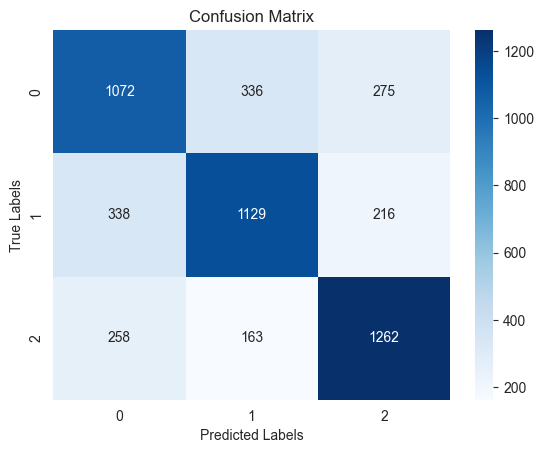

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(co_m, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Ok that was good enough

In [177]:
# tournament code 0 as default -> Tournament
def match_creator(team_1,team_2,tournament_code=0):
    # Get home and away codes
    home_code,away_code = country_codes[team_1],country_codes[team_2]
    # Randomize if game is played at neutral ground
    neutral = random.randint(0,1)
    # if not on neutral ground, pick either home or away as playing ground. Else pick a random ground
    hosting_country_code = random.choice([home_code,away_code]) if not neutral else random.choice(list(country_codes.values()))
    # Get most recent rank for home
    most_recent_rank_home = rank_at_year_df.loc[team_1,datetime.now().year]
    # Get most recent rank for away
    most_recent_rank_away = rank_at_year_df.loc[team_2,datetime.now().year]
    most_recent_rank_difference = most_recent_rank_home-most_recent_rank_away
    home_advantage = (country_codes[team_1] == hosting_country_code)
    game_info = {
        'home_team':team_1,
        'away_team':team_2,
        'date':datetime.now()
    }
    head_to_head_last_5 = calculate_head_to_head(game_info)
    goal_difference_last_5_home = calculate_goal_difference_last_5(game_info,'home_team')
    goal_difference_last_5_away = calculate_goal_difference_last_5(game_info,'away_team')
    days_since_last_match_home:pd.Series = (datetime.now() - game_results.loc[game_results['home_team'] == team_1].tail(1)['date']).to_list()[0].days
    days_since_last_match_away = (datetime.now() - game_results.loc[game_results['away_team'] == team_2].tail(1)['date']).to_list()[0].days
    wins_last_10_games = calculate_wins_last_10(game_info)
    home_fifa_pts = rank_at_year_df.loc[team_1,'{}_points'.format(datetime.now().year)]
    away_fifa_pts = rank_at_year_df.loc[team_2,'{}_points'.format(datetime.now().year)]
    match_data = {
        'neutral': neutral,
        'home_code':home_code,
        'away_code':away_code,
        'hosting_country_code':hosting_country_code,
        'tournament_code':tournament_code,
        'most_recent_rank_home':most_recent_rank_home,
        'most_recent_rank_away':most_recent_rank_away,
        'most_recent_rank_difference':most_recent_rank_difference,
        'home_advantage':home_advantage,
        'home_fifa_pts':home_fifa_pts,
        'away_fifa_pts':away_fifa_pts,
        'head_to_head_last_5':head_to_head_last_5,
        'goal_difference_last_5_home':goal_difference_last_5_home,
        'goal_difference_last_5_away':goal_difference_last_5_away,
        'days_since_last_match_home':days_since_last_match_home,
        'days_since_last_match_away':days_since_last_match_away,
        'wins_last_10_games':wins_last_10_games
    }
    match_idx = match_data.keys()
    return pd.Series(data=match_data.values(),index=match_idx).values.reshape(1,-1)

### USA vs Saudi Arabia

In [178]:
team_1, team_2 = 'United States','Saudi Arabia'
my_match = match_creator(team_1, team_2)
my_match[0]

NameError: name 'calculate_head_to_head' is not defined

In [ ]:
team_1 if clf.predict(my_match) == 2 else team_2

### Let's run our own little tournament!

In [ ]:
countries_to_match = ['Belgium','United States','Japan','Qatar','Saudi Arabia','England','Scotland','France','Brazil','Italy','Germany','Uruguay','Argentina','Spain','Mexico','Australia'] 

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
def run_tournament(teams,tournament_type='cup',hosting_country='random',with_print=True):
    if not teams:
        return 
    # Randomize teams
    random.shuffle(teams)
    # If tournament_type is 'cup' then draws are not allowed. One team must win!
    tab=''
    while len(teams) != 1:
        winners = []
        for i in range(0,len(teams),2):
            match = match_creator(teams[i],teams[i+1])
            if hosting_country != 'random':
                match = change_host(match,hosting_country,teams,i)
                # match[0][3] = country_codes[hosting_country]
                # match[0][0] = (match[0][3] != teams[i]) and (match[0][3] != teams[i+1])
                # match[0][8] = match[0][3] == teams[i]
            if len(teams) == 2: tab+='Final:'
            if with_print: print(tab,teams[i],'vs',teams[i+1],end=' -> ')
            # Initial prediction
            pred = clf.predict(match)
            if pred == 1 and tournament_type == 'cup':
                if with_print: print('Tie at full time. Playing extra-time.',end=' -> ')
                match = match_creator(teams[i],teams[i+1],tournament_code=1)
                if hosting_country != 'random': match = change_host(match,hosting_country,teams,i)
                pred = clf.predict(match)
                if pred == 1:
                    if with_print: print('Tie at extra time. Playing penalty shoot-outs.',end=' -> ')
                    match = match_creator(teams[i],teams[i+1],tournament_code=1)
                    if hosting_country != 'random': match = change_host(match,hosting_country,teams,i)
                    pred = clf.predict(match)
                    if pred == 1:
                        winner = teams[i] if random.randint(0,99) % 2 == 0 else teams[i+1]
                    else: 
                        winner = teams[i] if pred == 2 else teams[i+1]
                    if with_print: print(winner,'won after penalty shoot-outs!')
                else:
                    winner = teams[i] if pred == 2 else teams[i+1]
                    if with_print: print(winner,'won after extra time.')
            else:
                winner = teams[i] if pred == 2 else teams[i+1]
                if with_print: print(winner,'won after full time.')
            winners.append(winner)
        teams.clear()
        teams = winners
        tab+='\t'
    return teams[0]

def change_host(match,host,teams,i):
    match[0][3] = country_codes[host]
    match[0][0] = (match[0][3] != teams[i]) and (match[0][3] != teams[i+1])
    match[0][8] = match[0][3] == teams[i]
    return match
run_tournament(countries_to_match)

In [ ]:
rank_at_year_df.index.values

In [ ]:
def get_valid_countries(k):
    all_countries = list(rank_at_year_df.index.values)
    # For some reason these countries cause issues
    all_countries.remove('Yugoslavia')
    all_countries.remove('Serbia and Montenegro')
    all_countries.remove('Czechoslovakia')
    all_countries.remove('Netherlands Antilles')
    valid_countries = set()
    while len(valid_countries) != k:
        curr_country = random.choice(all_countries)
        val = country_codes.setdefault(curr_country,-1)
        if val != -1: valid_countries.add(curr_country)
    return list(valid_countries)

### Let's generate random countries and create a 64-team tournament

In [ ]:
world_cup = get_valid_countries(64)
country_ranks = {country:rank_at_year_df.loc[country,int(datetime.now().year)] for country in world_cup}
best_rank = min(country_ranks.values())
best_country = list(filter(lambda x: country_ranks[x] == best_rank,country_ranks.keys()))[0]
avg_rank = sum(country_ranks.values())/len(country_ranks.values())
print('Best country: {} - Ranked {}\nAverage Team Rank: {}'.format(best_country,best_rank,avg_rank))

In [ ]:
host = 'Brazil'
winner = run_tournament(world_cup,hosting_country=host,with_print=False)
print(winner,'wins the tournament!')
if winner != best_country:
    print('What a great tournament!')
else:
    print('The best team won, as expected.')
print('Tournament hosted by',host)

In [ ]:
i = 0
WC_wins = dict()
runs = 10
num_teams = 32
host='England'
while i != runs:
    print('run {}'.format(i))
    world_cup = get_valid_countries(num_teams)
    winner = run_tournament(teams=world_cup,hosting_country=host,with_print=False)
    WC_wins[winner] = (WC_wins.get(winner,0) + 1)
    i+=1
stats = dict()
for winner in WC_wins.keys():
    stats[winner] = WC_wins.get(winner)*100/runs
display(stats)